In [2]:
from math import tau
from operator import itemgetter

import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as LA
import pandas as pd
import scipy as sp
import scipy.signal as ss

plt.style.use('seaborn-notebook')
np.random.seed(293710966)

# Generazione del Segnale

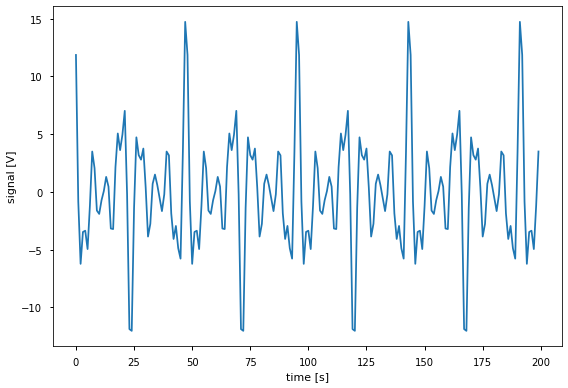

In [3]:
magnitudes = pd.read_csv('./harmonic-voltage-magnitude.csv', index_col='number')['typical']
phases = np.radians(pd.read_csv('./phases.csv', index_col='number'))['3.9']

power_freq = 50
sampling_freq = 2400
harmonic_numbers = np.arange(2, 14)

time = np.arange(4800.)

noise = 0.001 * np.random.normal(0, 1, time.size)
signal = noise.copy()

for n in harmonic_numbers:
    amp = magnitudes[n]
    phase = phases[n]
    omega = tau * n * power_freq / sampling_freq
    signal += amp * np.cos(omega * time + phase)

fig, ax = plt.subplots()
ax.plot(time[:200], signal[:200])
ax.set_xlabel('time [s]')
ax.set_ylabel('signal [V]')
fig.tight_layout()

In [5]:
time_window = 48 * 4
data_size = signal.size - time_window + 1

windows = [signal[i : i + time_window] for i in range(data_size)]
data_matrix = np.vstack(windows)

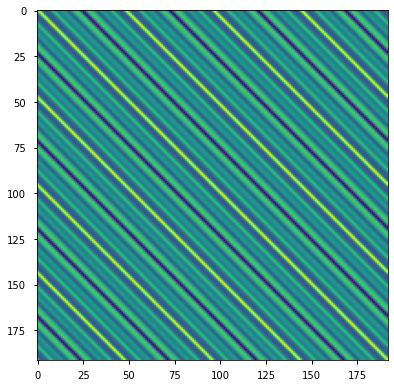

In [6]:
correlation = data_matrix.conj().T @ data_matrix / data_size

fig, ax = plt.subplots()
ax.imshow(correlation)
fig.tight_layout()

In [7]:
unsorted_pca = LA.eig(correlation)
pca = sorted(zip(*unsorted_pca), key=itemgetter(0), reverse=True)

signal_pca = list(zip(*pca[:harmonic_numbers.size]))
noise_pca = list(zip(*pca[harmonic_numbers.size:]))

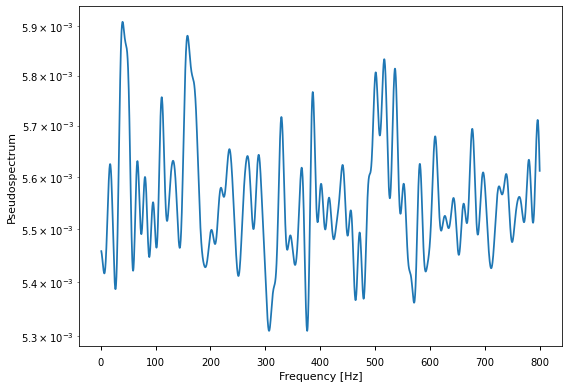

In [8]:
noise_eig = np.array(noise_pca[1])

freqs = np.linspace(1, 800, 2000)
omegas =  2 * np.pi * freqs / sampling_freq

# omegas = np.linspace(0, tau, 2000)
# freqs = omegas * sampling_freq / tau

pseudo_power = np.empty_like(omegas)

for i, omega in enumerate(omegas):
    steering = np.exp(1j * omega * np.arange(time_window))
    pseudo_power[i] = 1 / np.sum(np.abs(noise_eig @ steering.conj()) ** 2)
    
fig, ax = plt.subplots()
ax.plot(freqs, pseudo_power)
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Pseudospectrum')
ax.set_yscale('log')
fig.tight_layout()

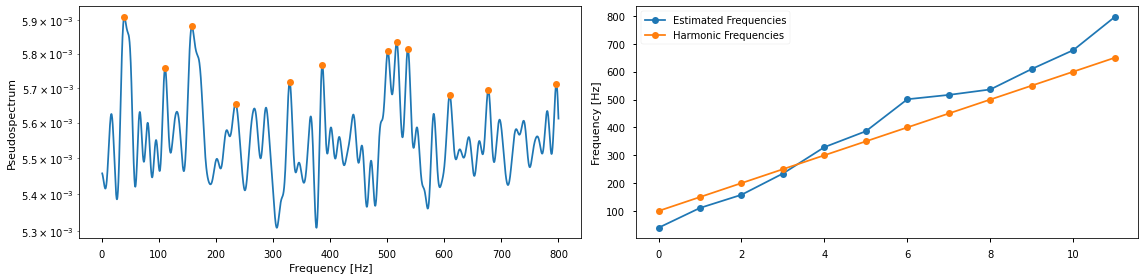

In [9]:
peaks_idx, _ = ss.find_peaks(pseudo_power)

peaks = pd.DataFrame()
peaks['omega'] = omegas[peaks_idx]
peaks['freq'] = freqs[peaks_idx]
peaks['power'] = pseudo_power[peaks_idx]
peaks = peaks.sort_values('power', ascending=False).head(harmonic_numbers.size).sort_values('omega')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(freqs, pseudo_power)
ax1.plot(peaks.freq, peaks.power, 'o');
ax1.set_xlabel('Frequency [Hz]')
ax1.set_ylabel('Pseudospectrum')
ax1.set_yscale('log')

ax2.plot(peaks.freq.values, 'o-', label='Estimated Frequencies')
ax2.plot(power_freq * harmonic_numbers, 'o-', label='Harmonic Frequencies')
ax2.set_ylabel('Frequency [Hz]')
ax2.legend()

fig.tight_layout()